This example demonstrates how to calculate the reflectivity with `transformer` and how to include the reflection effect from a far-field antenna model (still very basic and naive).

This example assumes that you are familiar with the package and just demonstrates how to include an antenna. If you are not familiar with the general package yet, please review the other examples.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#General-Init-/-Required-Packages" data-toc-modified-id="General-Init-/-Required-Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>General Init / Required Packages</a></span></li><li><span><a href="#Useful-Function-Defintions" data-toc-modified-id="Useful-Function-Defintions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Useful Function Defintions</a></span><ul class="toc-item"><li><span><a href="#Group-Delay" data-toc-modified-id="Group-Delay-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Group Delay</a></span></li><li><span><a href="#Gaussian-Beam" data-toc-modified-id="Gaussian-Beam-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Gaussian Beam</a></span></li><li><span><a href="#Beam-Shape-Plot" data-toc-modified-id="Beam-Shape-Plot-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Beam Shape Plot</a></span></li><li><span><a href="#Other" data-toc-modified-id="Other-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Other</a></span></li></ul></li><li><span><a href="#Antenna-Model" data-toc-modified-id="Antenna-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Antenna Model</a></span></li><li><span><a href="#The-Calculation-Itself" data-toc-modified-id="The-Calculation-Itself-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The Calculation Itself</a></span><ul class="toc-item"><li><span><a href="#General-Definitions" data-toc-modified-id="General-Definitions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>General Definitions</a></span></li><li><span><a href="#First-Reflection-on-the-Booster" data-toc-modified-id="First-Reflection-on-the-Booster-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>First Reflection on the Booster</a></span></li><li><span><a href="#Reflection-on-Antenna" data-toc-modified-id="Reflection-on-Antenna-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Reflection on Antenna</a></span></li><li><span><a href="#Second-Reflection-on-Booster" data-toc-modified-id="Second-Reflection-on-Booster-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Second Reflection on Booster</a></span></li><li><span><a href="#and-so-on..." data-toc-modified-id="and-so-on...-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>and so on...</a></span></li><li><span><a href="#Combining-Everything" data-toc-modified-id="Combining-Everything-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Combining Everything</a></span></li><li><span><a href="#Some-very-naive-thoughts-on-how-one-could-continue..." data-toc-modified-id="Some-very-naive-thoughts-on-how-one-could-continue...-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Some very naive thoughts on how one could continue...</a></span></li></ul></li></ul></div>

# General Init / Required Packages

In [1]:
#Parallelization
using Distributed

using PyCall
using PyPlot;
patch = pyimport("matplotlib.patches");

In [3]:
@everywhere begin
    # Uncomment the following line, if you just downloaded 
    # the githup repository and do not want to install the package:
    push!(LOAD_PATH, "../src"); 
    
    using BoostFractor;
end

# Useful Function Defintions

For people that have too much time: Maybe this stuff can/should be moved to a helper function file in the future ;-)

## Group Delay
$$ \tau_g := -\frac{{\rm d} \arg \Gamma}{{\rm d} \omega}, $$
where $\Gamma$ is the complex reflectivity and $\omega$ the angular frequency.

In [4]:
using DSP # Digital Signal Processing, used for unwrap()
function groupdelay(phase, df)
    return -diff(unwrap(phase))/(2pi*df)
end

groupdelay (generic function with 1 method)

## Gaussian Beam

In [5]:
function gauss_profile(;X = -0.4445:0.007:0.4445, Y = -0.4445:0.007:0.4445, x0=0, z = 0.000000001, 
        omega0 = 0.065, f = 22e9)
    radius = [sqrt((x-x0)^2 + y^2) for x in X, y in Y]
    c = 299792458.
    lambda = c/f
    #Gaussian Beam profile:   
    k = 2*pi/lambda
    zR = pi*omega0^2/lambda
    omega(z) = omega0*sqrt(1+(z/zR)^2)
    R(z)     = z*(1+(zR/z)^2)
    Psi(z)   = atan(z/zR)
        
   return omega0/omega(z) .* exp.(-radius.^2/omega(z)^2) .* exp.(-1im .* (k*z .+ k*radius.^2. /(2*R.(z)) .- Psi.(z))) 
end

gauss_profile (generic function with 1 method)

## Beam Shape Plot

In [6]:
function power_pattern_cuts(eout;radius=0.1,plottitle="", zlabel="Local Normalized Power \$\\propto \\left|\\frac{E}{E_0}\\right|^2\$", 
        plotcuts=true, dx=0.007, X = -0.4445:dx:0.4445)
    figure(figsize=(5.5,5) )
    
    ax2 = nothing
    ax3 = nothing
    powerpattern = abs2.(transpose(eout)) # for debug:[x for x in X, y in X]#
    max = maximum(powerpattern)
    
    if plotcuts
        ax2 = subplot2grid((10,11),(8,0), colspan=8, rowspan=2)
        plot(X, powerpattern[Int(ceil(length(X)/2)),:] )
        xlim((-0.2,0.2))
        ylim((-max*0.05,max*1.05))
        xlabel("x [m]")
        ylabel("\$\\left|\\frac{E}{E_0}\\right|^2\$")
        grid(alpha=0.5, linewidth=1)
        ax3 = subplot2grid((10,11),(0,8), rowspan=8, colspan=2)
        plot(powerpattern[:,Int(ceil(length(X)/2))], X)
        ylim((-0.2,0.2))
        xlim((-max*0.05,max*1.05))
        xlabel("\$\\left|\\frac{E}{E_0}\\right|^2\$")
        grid(alpha=0.5, linewidth=1)
    end
    
    ax1 = subplot2grid((10,11),(0,0), colspan=8, rowspan=8, sharex=ax2, sharey=ax3)
    imshowresult = imshow(powerpattern, interpolation="bessel" , extent=[minimum(X),maximum(X),maximum(X),minimum(X)], aspect="auto") #
    c = patch.Circle((0,0),radius=radius, color="white", fill=false, linewidth=0.5)
    gca()[:add_artist](c)
    xlim((-1.5*radius,1.5*radius))
    ylim((-1.5*radius,1.5*radius))
    axvline(x=X[Int(ceil(length(X)/2))], color="white", linewidth=0.5, alpha=0.5)
    axhline(y=X[Int(ceil(length(X)/2))], color="white", linewidth=0.5, alpha=0.5)
    
    ax1[:tick_params](labelbottom=false)    
    ax3[:tick_params](labelleft=false)
    
    ylabel("y [m]")
    title(plottitle)
    
    ax4 = subplot2grid((10,11),(0,10), rowspan=8)
    colorbar(imshowresult, label=zlabel, cax=ax4)
    
    sca(ax1)
end

power_pattern_cuts (generic function with 1 method)

## Other

In [7]:
@everywhere zcat(args...) = cat(dims = 3, args...)

# Antenna Model

We define our antenna in the following way:
 1. <b>In the Far Field of the Booster</b><br> 
    We assume that the antenna itself is (sufficiently) in the far field of the booster. This is equivalent to thinking about the antenna as a sphere in the limit of infinite radius surrounding the booster. Beams matching the antenna beam are absorbed by the sphere, beams not matching the antenna beam are reflected by the sphere (see also below). In particular notice that everywhere at the sphere the beam impinges perpendicularly to it if the sphere is sufficiently far away. In particular, any of these plane waves travels the same distance between booster and the sphere, i.e., any beam reflected by the sphere arrives back at the booster with the same beam shape as it has originated.
    
    <b><i>How to generalize from this approximation:</i></b><br>
    In reality we have a focusing mirror to transform into the far field 'quickly'.
    This situation will generally be slightly different from the arguments described above, i.e., the part of the beam which is not absorbed, might not be reflected exactly in the same shape as it originated on the booster. This could be analyzed for example with Laguerre Gaussian modes. Higher modes generally diverge faster between the antenna and the booster, so they
    might be not mapped by the antenna completely onto themselves after the reflection onto the booster. This needs more quantification and dedicated simulation work, i.e., analyze how different modes emitted by the booster behave when they come back.
    
    
 2. <b>No Loss</b><br>
    We assume there is no loss, i.e., everything must be received by the antenna or reflected.
    
    <b><i>How to generalize from this approximation:</i></b><br>
    We can include loss in this kind of model by just adding a 
    loss during the propagation between antanna and booster, as well as on the received field.
    Then we can calculate the couplings analogous to the above, when using the fields already
    taking into account the loss between the booster and antenna on the fields that arrive at the antenna.
    
    
  3. <b>Single Port</b>
     This is less important and most common for most antennas: We assume that the antenna is coupled to a waveguide/coax cable that only supports one mode of propagation, so the recieved/sent signal is sufficiently well described as a complex scalar quantity.
    
Assume we know which beam shape the antenna whould emit, if we use it as a sender. Due to reciprocity, this is the only beam shape, which the antenna can receive; every other beam is reflected.
Knowing this beam shape $E_b$ on an arbitrary surface $A$ infront of the antenna, the antenna then receives a field amplitude of
$$ \langle E_b | E_a \rangle \  = \ \int dA E_b^* \cdot E_a,$$
where $E_b$ is the incoming beam and $E_a$ is normalized to power 1.
The reflected beam is a beam shape that must be orthogonal to $E_a$, i.e., we find it by
$$ |E_r \rangle = |E_b \rangle - \langle E_b | E_a \rangle |E_a \rangle ,$$
which fulfills
$$ \langle E_r | E_a \rangle \  = \ \int dA E_r^* \cdot E_a = 0. $$
    
    
Another note: The code below can be used without modification (except obvioulsy for how the booster itself is calculated) if the booster would be described with more newer code from Johannes which uses vector fields instead of scalar fields. So scalar fields is not an assumption explicitly needed here.

In [8]:
# Function that calculates the complex matching ratio <e1|e2>
matching(e1,e2;dims=1) = sum(e1.*conj.(e2), dims=dims)

matching (generic function with 1 method)

In [9]:
# The component of e1 orthogonal to e2 (e.g. the reflected modes given matched modes e2)
orthogonal(e1,e2,dims=1) = e1 .- matching(e1,e2;dims=dims)./sqrt(sum(abs2.(e2))).*e2./sqrt(sum(abs2.(e2)))

orthogonal (generic function with 2 methods)

# The Calculation Itself

## General Definitions
First we define the booster to simulate. We will use a single disk + mirror setup with a relative tilt between both of $8\,{\rm mrad}$.

In [10]:
# The booster itself

@everywhere begin
    # Coordinate System
    dx = 0.007
    coords = SeedCoordinateSystem(X = -0.301:dx:0.301, Y = -0.301:dx:0.301)
    
    diskR = 0.1
    
    # Booster
    epsilon = 9.4
    eps = Array{Complex{Float64}}([1e10,1-1im*0.03,epsilon,1])
    distance = [0,7.5,1,0]*1e-3;    
    relative_tilt_x = [0,8,0,0]*1e-3;
    relative_tilt_y = zeros(4) 
    relative_surfaces = zeros(4,1,1);
        
    sbdry = SeedSetupBoundaries(coords, diskno=1, distance=distance, epsilon=eps,
                                relative_tilt_x=relative_tilt_x,
                                relative_tilt_y=relative_tilt_y,
                                relative_surfaces=relative_surfaces)
   
    # Modes (use 6,4 for better results)
    Mmax = 2 #6
    Lmax = 2 #4
    modes = SeedModes(coords, ThreeDim=true, Mmax=Mmax, Lmax=Lmax, diskR=diskR)
end

In [11]:
# Frequency Range
df = 0.002*1e9
frequencies = 19.25e9:df:22e9

1.925e10:2.0e6:2.2e10

<b>Antenna Beam Shape</b><br>
We use a definition close to the lab setup in Munich with a beam waist at the front disk of $w_0 = 55\,{\rm mm}$.

In [12]:
# Initialize the Beam Shape of the antenna
m_inc = BoostFractor.field2modes(gauss_profile(;omega0=0.055,x0=-0.00,X=coords.X,Y=coords.X,z=0.0000001), 
    coords, modes;diskR=diskR)
m_antenna_in = conj.(m_inc); # complex conjugate = time reversed

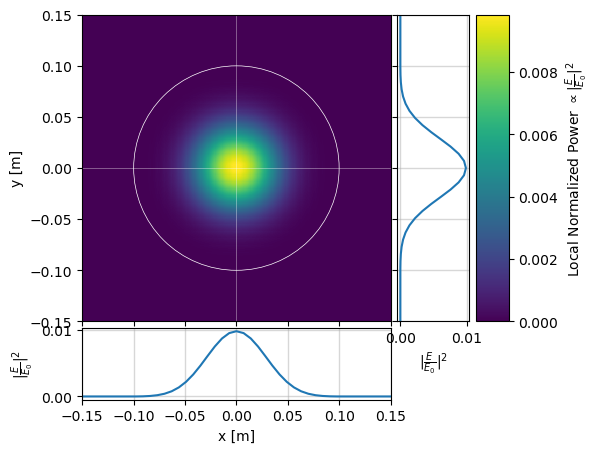

In [13]:
power_pattern_cuts((BoostFractor.modes2field(m_antenna_in, coords, modes)[:,:,1]),radius=0.1,X=coords.X)

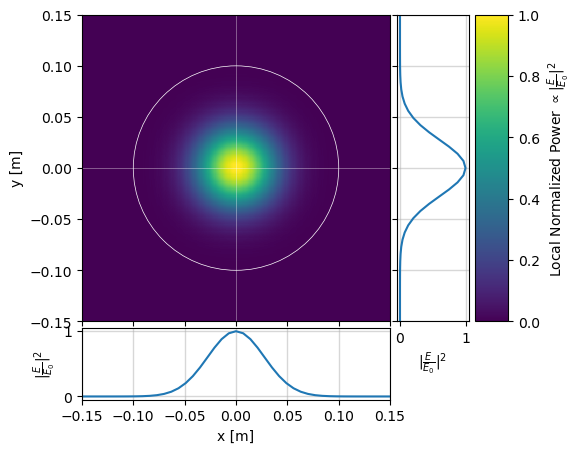

In [14]:
# As a comparision plot the antenna beam shape
power_pattern_cuts((gauss_profile(;omega0=0.055,x0=-0.00,X=coords.X,Y=coords.X,z=0.00000001)),
    radius=0.1,X=coords.X)

## First Reflection on the Booster

At first the antenna will shine its antenna beam onto the booster. Here we calculate the response of the booster to that.

In [26]:
@everywhere using BoostFractor

@time EoutModesTilt = @sync @distributed (zcat) for f in frequencies
    boost, refl = transformer(sbdry, coords,modes; reflect=m_antenna_in, prop=propagator,f=f, diskR=0.1)
    transpose([boost  refl])
end;

  6.281450 seconds (1.02 M allocations: 68.307 MiB, 0.63% gc time)


Let's see how much power we lose on the first reflection:

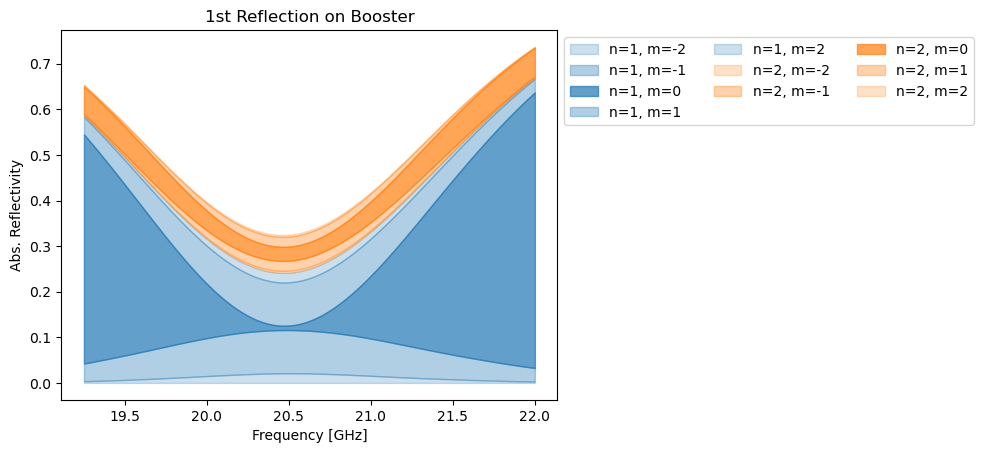

PyObject Text(0.5, 24.0, 'Frequency [GHz]')

In [27]:
tot = zeros(length(EoutModesTilt[2,1,:]))
for m in 1:(modes.M*(modes.L*2+1))
    l = (m-1)%(modes.L*2+1)-modes.L
    n = Int( floor((m-1)/(modes.L*2+1))+1 )
    fill_between(frequencies/1e9,tot, tot.+abs2.(EoutModesTilt[2,m,:]), alpha=0.7/(1+abs(l)), label="n=$n, m=$l", color="C$(n-1)")
    tot .+= abs2.(EoutModesTilt[2,m,:])
end
legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=3)
title("1st Reflection on Booster")
ylabel("Abs. Reflectivity")
xlabel("Frequency [GHz]")


And how the group delay looks if we could "perfectly time gate" the first reflection, i.e., the antenna would absorb everything that does not couple to it:

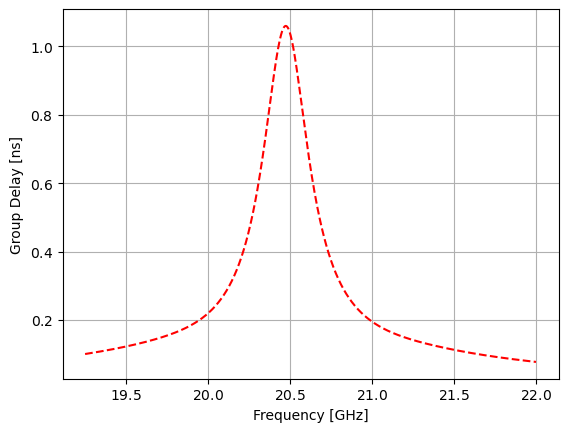

PyObject Text(0.5, 24.0, 'Frequency [GHz]')

In [28]:

Eout = EoutModesTilt


freqs_gd_plot = (frequencies[2:end].-df/2)/1e9
plot(freqs_gd_plot, 1e9 .*groupdelay(angle.(matching(Eout[2,:,:],m_inc)[1,:]),df), alpha=1, c="r", linestyle="--")

#= 

# The following will show each mode individually, but that does not
# make much sense physically, since we cannot receive each mode
# individually:

for m in 1:(BoostFractor.M*(BoostFractor.L*2+1))
    l = (m-1)%(BoostFractor.L*2+1)-BoostFractor.L
    n = Int( floor((m-1)/(BoostFractor.L*2+1))+1 )
    plot(freqs_gd_plot, 1e9 .*groupdelay(angle.((Eout[2,m,:])),df),alpha=(l == 0 ? (n==1 ? 1.0 : 0.6) : 0.3), label="Mode n=$n, m=$l",linewidth=1, c="C$(n-1)")
end
legend(loc="upper left", bbox_to_anchor=(1, 1))
=#


ticklabel_format(axis="both", scilimits=(-2,2), useMathText=true)
grid()
ylabel("Group Delay [ns]")
xlabel("Frequency [GHz]")

... and an analogous plot to the first one could be done for the boost factor (left to the reader).

## Reflection on Antenna

Assuming the antenna reflects everything it cannot receive, we end up with a reflected beam shape that is orthogonal to the one of the antenna:

In [29]:
orthogonalmodes = orthogonal(EoutModesTilt[2,:,:], m_inc);

# The same line if you wanted to do it with the boost factor (instead of reflectivity):
# orthogonalmodes = orthogonal(EoutModesTilt[1,:,:], m_inc)

In addition, the beam that comes back will be phase shifted according to the distance to the antenna.
Note that using a single phase is still an approximation of the far field antenna (see above, the far field "sphere" has a radius of $d/2$ here).


When looking only at the individual bits (first reflection on booster / second reflection on booster) this phase does not matter, but it matters when adding these contributions up, so we will only include it at the very end.

In [30]:
c=3e8
wavelength=c./frequencies
k0 = transpose(2pi./wavelength)
d = 5.0 # m
phasefactor = exp.(-1im*d.*k0);

Let's look at what is reflected by the antenna. Notice that the fundamental mode is almost not reflected, since the antenna couples well to it. 

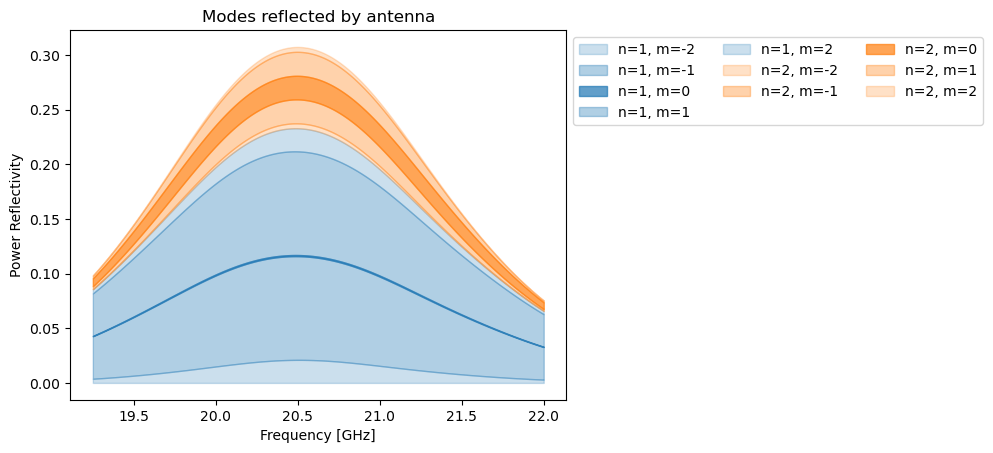

PyObject Text(0.5, 24.0, 'Frequency [GHz]')

In [31]:
tot = zeros(length(EoutModesTilt[2,1,:]))
for m in 1:(modes.M*(modes.L*2+1))
    l = (m-1)%(modes.L*2+1)-modes.L
    n = Int( floor((m-1)/(modes.L*2+1))+1 )
    fill_between(frequencies/1e9,tot, tot.+abs2.(orthogonalmodes[m,:]), alpha=0.7/(1+abs(l)), label="n=$n, m=$l", color="C$(n-1)")
    tot .+= abs2.(orthogonalmodes[m,:])
end
legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=3)
title("Modes reflected by antenna")
ylabel("Power Reflectivity")
xlabel("Frequency [GHz]")

## Second Reflection on Booster

In [32]:
@time EoutModes2ndReflectionTilt = @sync @distributed (zcat) for i in 1:length(frequencies)
    boost, refl = transformer(sbdry, coords, modes; reflect=orthogonalmodes[:,i], prop=propagator,f=frequencies[i], diskR=0.1)
    transpose([boost  refl])
end;

  3.966139 seconds (209.09 k allocations: 26.970 MiB)


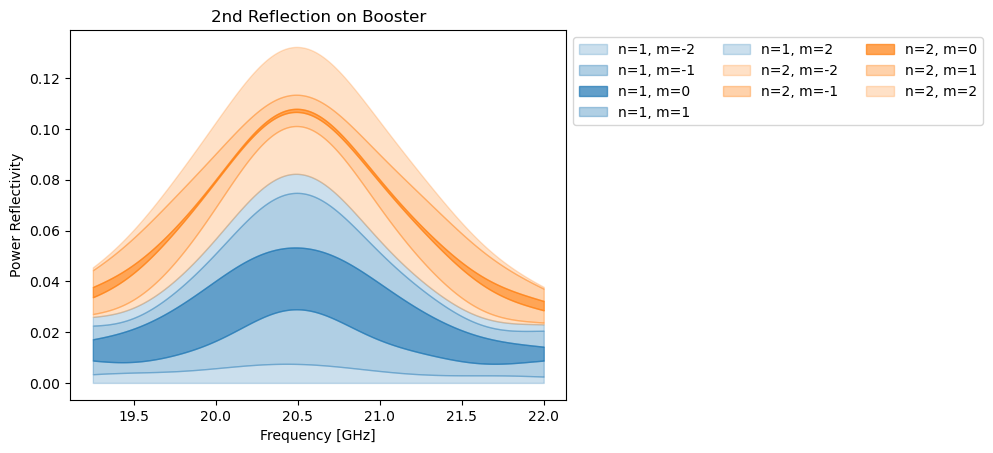

PyObject Text(0.5, 24.0, 'Frequency [GHz]')

In [33]:
tot = zeros(length(EoutModes2ndReflectionTilt[2,1,:]))
for m in 1:(modes.M*(modes.L*2+1))
    l = (m-1)%(modes.L*2+1)-modes.L
    n = Int( floor((m-1)/(modes.L*2+1))+1 )
    fill_between(frequencies/1e9,tot, tot.+abs2.(EoutModes2ndReflectionTilt[2,m,:]), alpha=0.7/(1+abs(l)), label="n=$n, m=$l", color="C$(n-1)")
    tot .+= abs2.(EoutModes2ndReflectionTilt[2,m,:])
end
legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=3)
title("2nd Reflection on Booster")
ylabel("Power Reflectivity")
xlabel("Frequency [GHz]")

## and so on...
In principle this could be iteratively repeated as often as you want to include higher orders of reflection. At a later stage one could think about explicitly including it in the transfer matrices to automatically take it into account (todo...).

## Combining Everything
Whatever is plotted above cannot be measured, since only the reflectivity of the full system including the antenna can be measured. Below a demonstration how to combine above data to get the measured reflectivity and plot the group delay including the antenna. For the absolute power it is analogous and thus left to the reader.

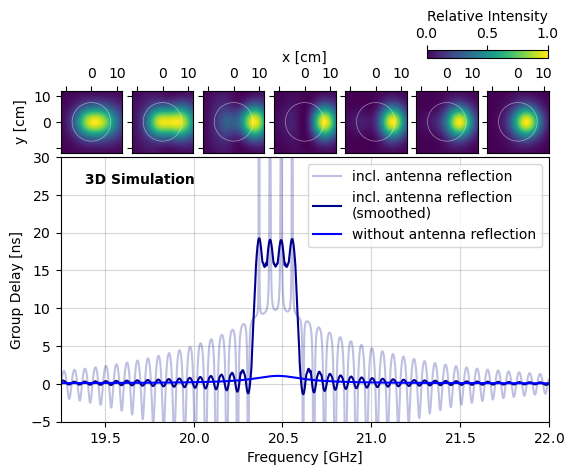

In [34]:
using ImageFiltering 
# ^-- used to smooth the data, the VNA (device to measure the reflectivity) is doing this, too

nrows= 5
fig, axes = subplots(nrows=nrows, ncols=7, sharex=true, sharey=true, figsize=(9*0.7,6*0.7))


subplot2grid((nrows,7),(1,0), colspan=7, rowspan=4)


freqs_gd_plot = (frequencies[2:end].-df/2)/1e9

groupdelaycurve = groupdelay(angle.(matching(EoutModesTilt[2,:,:].+phasefactor.*EoutModes2ndReflectionTilt[2,:,:],m_inc)[1,:]),df)
plot(freqs_gd_plot, groupdelaycurve.*1e9, c="darkblue",label="incl. antenna reflection", alpha=0.25)

ker = ImageFiltering.Kernel.gaussian((10,))
groupdelay_filtered = imfilter(groupdelaycurve, ker)
plot(freqs_gd_plot, groupdelay_filtered.*1e9, c="darkblue", alpha=1,label="incl. antenna reflection\n(smoothed)")

plot(freqs_gd_plot, groupdelay(angle.(matching(EoutModesTilt[2,:,:],m_inc)[1,:]),df).*1e9, alpha=1, c="blue",label="without antenna reflection")



ylim(-5,30)
legend(loc="upper right")
ticklabel_format(axis="both", scilimits=(-2,2), useMathText=true)
grid(alpha=0.5)
ylabel("Group Delay [ns]")
xlabel("Frequency [GHz]")
xlim(19.25,22)

text(0.05,0.9, "3D Simulation", ha="left", fontweight="bold", transform=gca().transAxes)

ims = nothing
# Plot the beam shapes

# To propagate them a bit we use a new coordinate system to accomodate more borader diffraction
Xn = -1.701:0.007:1.701
Yn = -1.701:0.007:1.701
newcoords = SeedCoordinateSystem(X = Xn, Y = Yn)

# Now iterate over the different beam shapes that we want to show
# equaidistantly over the shown frequency range
for k in 0:1:6
    idx = Int(floor((k+0.5)*length(frequencies)/7))
    emodes_tot = EoutModesTilt[2,:,idx] 
    fielddist = BoostFractor.modes2field(emodes_tot, coords, modes)
    
    fielddistembed = complex.(zeros(length(Xn), length(Yn)))
    xs = length(-1.701:0.007:-0.301)
    fielddistembed[xs:xs+length(coords.X)-1,xs:xs+length(coords.X)-1] = fielddist

    fielddistprop = BoostFractor.propagatorNoTilts(fielddistembed, 0.8, Inf, 1, 0, 0, 
        ones(length(Xn),length(Yn)), 0.015, newcoords)
    
    
    subplot2grid((nrows,7),(0,k))
    ims = imshow(transpose(abs2.(fielddistprop)./maximum(abs2.(fielddistprop))), origin="lower", extent=(-170.1, 170.1, -170.1, 170.1))
    xlim(-12,12)
    ylim(-12,12)
    
    gca().xaxis.tick_top()
    gca().xaxis.set_label_position("top") 
    
    if k == 0
        ylabel("y [cm]")
    else
        gca()[:tick_params](labelleft=false)
    end
    if k == 3
        xlabel("x [cm]")
    end
    
    
    radius = 7.5
    c = patch.Circle((0,0),radius=radius, color="white", fill=false, linewidth=0.5, alpha=0.5)
    gca()[:add_artist](c)
    xticks(-10:10:10,["", "0", "10"])
    yticks(-10:10:10,["", "0", "10"])
end



fig.subplots_adjust(top=0.9, wspace=0.15, hspace=0.05)
cbar_ax = fig.add_axes([0.13+0.768*0.75, 0.975, 0.768*0.25, 0.02])
fig.colorbar(ims, cax=cbar_ax, orientation="horizontal", label="Relative Intensity")

gca().xaxis.tick_top()
gca().xaxis.set_label_position("top") 


#savefig("groupdelay_beamshape_reflectivity_sim.pdf", bbox_inches="tight")


## Some very naive thoughts on how one could continue...
 * Do the simulation for a single tilted disk and far field antenna also with Comsol, maybe in 2D, and compare with result from this code.
 * Update propagation model between antenna and booster (go away from perfect far field antenna). Maybe formulate in terms of Laguerre Gaussian modes, or similar?
 * For example by: Study other simulation programs like Grasp for antenna design, implement our antenna + mirror model and try to see what happens with different modes emitted by the booster.
 
 
 * Calculate the 20 disk booster, assume a prototype antenna matched to the fundamental mode
 * Include the antenna reflection effect explicit in the studies for roughness, tilting, thickness variation effects
 * ...